In [23]:
import xarray as xr

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgcm
from typing import Annotated
from xhistogram.xarray import histogram
import xrft
from xgcm import Grid

In [2]:
def open_llc4320_velocity_data(chunks='auto', time_range=None):
    
    ds_SSU = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssu", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    ds_SSV = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssv", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    # Open grid data
    ds_grid = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/grid", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    coords_to_keep = ['XC', 'YC', 'dxC', 'dyC', 'dxG', 'dyG', 'rAz', 'rA', 'Depth']
    ds_grid = ds_grid.reset_coords()[coords_to_keep]
    
    ds = xr.merge([ds_SSU, ds_SSV, ds_grid])
    
    if time_range is not None:
        ds = ds.isel(time=time_range)
        
    ds = ds.chunk(chunks)
    
    return ds, ds_grid

In [3]:
ds, ds_grid = open_llc4320_velocity_data(chunks={})

In [4]:
grid = xgcm.Grid(ds_grid, periodic=False)

In [5]:



@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def vort(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
    raz: Annotated[np.ndarray, "(Y:left,X:left)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    """Dimensional vorticity"""
    
    u_trans = u * dxc
    v_trans = v * dyc
    v_diff_x = v_trans[..., 1:, 1:] - v_trans[..., 1:, :-1]
    u_diff_y = u_trans[..., 1:, 1:] - u_trans[..., :-1, 1:]
    return (v_diff_x - u_diff_y) / raz[..., 1:, 1:]

@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def strain(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
    v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
    u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_x_trimmed = v_diff_x[..., 1:, :]
    u_diff_y_trimmed = u_diff_y[..., 1:]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    strain_normal = u_diff_x_trimmed - v_diff_y_trimmed
    strain_shear = v_diff_x_trimmed + u_diff_y_trimmed
    
    # TODO: interpolate the shear strain onto the positions of the normal strain
    # For now, we just pretend they are at the same grid point
    strain_mag = np.sqrt(strain_normal ** 2 +  strain_shear ** 2)
    
    return strain_mag

@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",
)
def divergence(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxg: Annotated[np.ndarray, "(Y:left,X:center)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyg: Annotated[np.ndarray, "(Y:center,X:left)"],
    ra:  Annotated[np.ndarray, "(Y:center,X:center)"],
) ->     Annotated[np.ndarray, "(Y:center,X:center)"]:
    
    u_diff_x = (u[..., 1:] - u[..., :-1]) * dxg[..., 1:]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) * dyg[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    divergence = (u_diff_x_trimmed + v_diff_y_trimmed) / ra[..., 1:, 1:]
    
    return divergence

In [6]:
def vort_strain_div_bins(n_strain_bins=100, n_vort_bins=200, n_div_bins=200, vort_max=5, strain_max=5, div_max=5):
    vort_bins = np.linspace(-vort_max, vort_max, n_vort_bins)
    strain_bins = np.linspace(0.0, strain_max, n_strain_bins)
    div_bins = np.linspace(-div_max, div_max, n_div_bins)
    return vort_bins, strain_bins, div_bins

In [7]:
vort_bins, strain_bins, div_bins = vort_strain_div_bins(n_strain_bins=50, n_vort_bins=100, n_div_bins=100)
a = np.diff(vort_bins)[0]*np.diff(strain_bins)[0]*np.diff(div_bins)[0]

In [8]:
ζ = vort(grid, ds.U, ds.dxC, ds.V, ds.dyC, ds.rAz, axis= 5 * [("Y", "X")])
σ = strain(grid, ds.U, ds.dxC, ds.V, ds.dyC, axis=4 * [("Y", "X")])
D = divergence(grid, ds.U, ds.dxG, ds.V, ds.dyG, ds.rA, axis= 5 * [("Y", "X")])

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in orde

In [9]:
tdiff = 240
tstep=24
σ_piece = σ.isel(time=slice(2736,2736+tdiff,tstep)).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(1100,1650)).rename({"i_g": "i", "j_g": "j"})/10**-4
ζ_piece = ζ.isel(time=slice(2736,2736+tdiff,tstep)).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(1100,1650)).rename({"i_g": "i", "j_g": "j"})/(-10**-4)
D_piece = D.isel(time=slice(2736,2736+tdiff,tstep)).sel(face=1).isel(i=slice(0,550)).isel(j=slice(1100,1650))/10**-4

In [10]:
ds.sel(face=1).YC.isel(i=slice(0,550)).isel(j=slice(1100,1650)).min().values

array(-43.23789, dtype=float32)

/tmp/ipykernel_87/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_87/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_87/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_87/2510200718.py:37: RuntimeWarning: invalid value encountered in divide
  v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]


In [11]:
h = histogram(
    ζ_piece.rename('vort'),
    σ_piece.rename('strain'),
    D_piece.rename('div'),
    bins=[vort_bins, strain_bins, div_bins],
    block_size=None,  # avoids a divide-by-zero bug in xhistogram's code for automatically determining block_size
    density=False,  # setting this to true leads to an error right now
    keep_coords=True,
)
h = h/a/550/550

In [12]:
h_DivPdf = (h*h.div_bin).mean('div_bin').load()

/tmp/ipykernel_87/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_87/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_87/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_87/2510200718.py:37: RuntimeWarning: invalid value encountered in divide
  v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_87/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_87/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_87/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] - u[...,

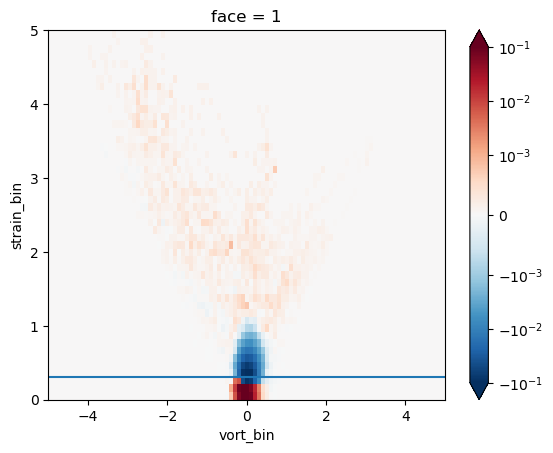

In [13]:
h_DivPdf.plot(x='vort_bin', vmax=0.1, norm=mpl.colors.SymLogNorm(1e-3))
plt.axhline(0.3)

In [152]:
tdiff = 240
tstep=1

u_piece_g = ds.U.isel(time=slice(2736,2736+tdiff,tstep)).sel(face=1).isel(i_g=slice(0,550)).isel(j=slice(1100,1650))
v_piece_g = ds.V.isel(time=slice(2736,2736+tdiff,tstep)).sel(face=1).isel(i=slice(0,550)).isel(j_g=slice(1100,1650))
ds2 = u_piece_g.to_dataset().merge(v_piece_g)

ds2 = ds2.drop_vars('time')
grid = Grid(ds2)
u_piece = grid.interp(ds2.U,'X')
v_piece = grid.interp(ds2.V,'Y')


/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [153]:
u_piece.time.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [154]:
u2_psa = xrft.power_spectrum(u_piece.load(), dim=['i','j','time'],window=True,window_correction=True).compute()
v2_psa = xrft.power_spectrum(v_piece.load(), dim=['i','j','time'],window=True,window_correction=True).compute()
vel_psa = (u2_psa + v2_psa)*0.5

/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


In [155]:
def azimuthal_avg(k, l, f, N, nfactor):
    """
    Takes the azimuthal average of a given field.
    """
    k = k.values; l = l.values
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area

    if f.ndim == 2:
        iso_f = np.ma.masked_invalid(np.bincount(kidx,
                                    weights=f.data.ravel())
                                    / area) * kr
    else:
        raise ValueError('The data has too many or few dimensions. '
                        'The input should only have the two dimensions '
                        'to take the azimuthal averaging over.')

    return kr, iso_f

In [156]:
vel_ps=np.zeros((138,240))
for i in range(0,240):
    vel_ps[:,i] = azimuthal_avg(vel_psa.freq_i, vel_psa.freq_j, vel_psa[i,:,:],len(vel_psa.freq_i), 4)[1]
kr = azimuthal_avg(vel_psa.freq_i, vel_psa.freq_j, vel_psa[i,:,:],len(vel_psa.freq_i), 4)[0]
#azimuthal_avg(u_psa.freq_i, u_psa.freq_j, u_psa[1,:,:],len(u_psa.freq_i), 4)[0]

/tmp/ipykernel_87/4157574309.py:17: RuntimeWarning: invalid value encountered in divide
  kr = np.bincount(kidx, weights=K.ravel()) / area
/tmp/ipykernel_87/4157574309.py:20: RuntimeWarning: invalid value encountered in divide
  iso_f = np.ma.masked_invalid(np.bincount(kidx,


In [159]:
kr.shape

(138,)

In [158]:
vel_psa.freq_time[120]

<xarray.DataArray 'freq_time' ()> Size: 8B
array(0.)
Coordinates:
    freq_time  float64 8B 0.0
Attributes:
    spacing:  0.004166666666666652

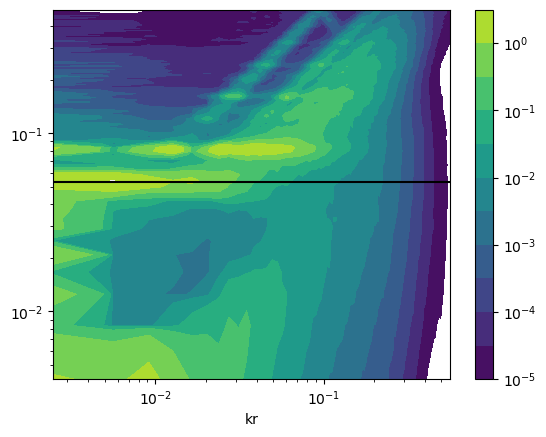

In [184]:
omega = vel_psa.freq_time.values*3600

cs = plt.contourf(kr[1:], vel_psa.freq_time[121:].values,(vel_ps*omega*np.expand_dims(kr,1)).T[121:,1:], norm=mpl.colors.LogNorm(),vmax=10**1, levels=10.**np.arange(-5,1,0.5))
plt.colorbar(cs)
plt.xlabel('kr')
plt.xscale('log')
plt.yscale('log')
plt.axhline(3600*0.93*10**-4/np.pi/2,color='k')
#plt.ylim(10**-6,2*10**-4)

In [187]:
def sinc2(x, a):
        return np.sinc(x/a)
window_width=30
f=0.8*10**-4
weight = xr.DataArray(sinc2(np.arange(-window_width/2,window_width/2),np.expand_dims(np.pi/f/3600,0)*1.1), dims=['window'])
#u_filt = ds.U.sel(face=1).isel(i_g=slice(0,550)).isel(j=slice(1100,1650),time=slice(2736,2736+30)).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')


In [193]:
#This seems to be working 
tdiff = 240
tstep=1
ds_sec = ds.sel(face=1).isel(i=slice(0,550)).isel(i_g=slice(0,550)).isel(j=slice(1100,1650)).isel(j_g=slice(1100,1650))
def sinc2(x, a):
        return np.sinc(x/a)
window_width=30
f=0.8*10**-4
weight = xr.DataArray(sinc2(np.arange(-window_width/2,window_width/2),np.expand_dims(np.pi/f/3600,0)*1.1), dims=['window'])
u_filt = ds_sec.U.isel(time=slice(2736,2736+tdiff,tstep)).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
v_filt = ds_sec.V.isel(time=slice(2736,2736+tdiff,tstep)).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')

u_pert = ds_sec.U.isel(time=slice(2736,2736+tdiff,tstep)) - u_filt

v_pert = ds_sec.V.isel(time=slice(2736,2736+tdiff,tstep)) - v_filt

/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/array/core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 30
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/array/core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 30
  result = blockwise(


In [195]:
grid1 = xgcm.Grid(ds_sec.isel(time=slice(2736,2736+tdiff,tstep)), periodic=False)

In [203]:
ds_sec.U

<xarray.DataArray 'U' (time: 9030, j: 550, i_g: 550)> Size: 11GB
dask.array<getitem, shape=(9030, 550, 550), dtype=float32, chunksize=(1, 550, 550), chunktype=numpy.ndarray>
Coordinates:
    face     int64 8B 1
  * i_g      (i_g) int64 4kB 0 1 2 3 4 5 6 7 ... 542 543 544 545 546 547 548 549
  * j        (j) int64 4kB 1100 1101 1102 1103 1104 ... 1645 1646 1647 1648 1649
  * time     (time) datetime64[ns] 72kB 2011-09-13 ... 2012-09-23T05:00:00

In [219]:
ζ_filt = vort(grid1, u_filt.isel(time=30)*xr.ones_like(ds_sec.U.isel(time=30)), ds_sec.dxC, v_filt.isel(time=30)*xr.ones_like(ds_sec.V.isel(time=30)), ds_sec.dyC, ds_sec.rAz, axis= 5 * [("Y", "X")])
σ_filt = strain(grid1, u_filt.isel(time=30)*xr.ones_like(ds_sec.U.isel(time=30)), ds_sec.dxC, v_filt.isel(time=30)*xr.ones_like(ds_sec.V.isel(time=30)), ds_sec.dyC, axis=4 * [("Y", "X")])
D_filt = divergence(grid, u_filt.isel(time=30)*xr.ones_like(ds_sec.U.isel(time=30)), ds_sec.dxG, v_filt.isel(time=30)*xr.ones_like(ds_sec.V.isel(time=30)), ds_sec.dyG, ds_sec.rA, axis= 5 * [("Y", "X")])

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in orde

In [221]:
ζ_unfilt = vort(grid1, ds_sec.U.isel(time=30), ds_sec.dxC, ds_sec.V.isel(time=30), ds_sec.dyC, ds_sec.rAz, axis= 5 * [("Y", "X")])
σ_unfilt = strain(grid1, ds_sec.U.isel(time=30), ds_sec.dxC, ds_sec.V.isel(time=30), ds_sec.dyC, axis=4 * [("Y", "X")])
D_unfilt = divergence(grid, ds_sec.U.isel(time=30), ds_sec.dxG, ds_sec.V.isel(time=30), ds_sec.dyG, ds_sec.rA, axis= 5 * [("Y", "X")])

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in orde

In [ ]:
D_filt.where(σ_filt>0.3).plot(levels=np.arange(-1,1,0.01)*10**-4)

In [209]:
ds_sec.U.isel(time=30).i_g

<xarray.DataArray 'i_g' (i_g: 550)> Size: 4kB
array([  0,   1,   2, ..., 547, 548, 549], shape=(550,))
Coordinates:
    face     int64 8B 1
  * i_g      (i_g) int64 4kB 0 1 2 3 4 5 6 7 ... 542 543 544 545 546 547 548 549
    time     datetime64[ns] 8B 2011-09-14T06:00:00
Attributes:
    axis:               X
    c_grid_axis_shift:  -0.5
    long_name:          x-dimension of the u grid
    standard_name:      x_grid_index_at_u_location
    swap_dim:           XG

In [63]:
tdiff = 240
tstep=24
σ_piece_pert = σ_pert.rename({"i_g": "i", "j_g": "j"})/10**-4
ζ_piece_pert = ζ_pert.rename({"i_g": "i", "j_g": "j"})/(-10**-4)
D_piece_pert = D_pert/10**-4

In [65]:
D_piece_pert#.where((σ_piece_pert>0.3)& (np.abs(ζ_piece_pert)<0.3)).isel(time=0).plot()

<xarray.DataArray (time: 10, j: 4320, i: 4320)> Size: 1GB
dask.array<truediv, shape=(10, 4320, 4320), dtype=float64, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 35kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 35kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
Dimensions without coordinates: time

In [ ]:
(D_piece.where((σ_piece>0.3)& (np.abs(ζ_piece)<0.3)).isel(time=0)
 -D_piece_pert.where((σ_piece_pert>0.3)& (np.abs(ζ_piece_pert)<0.3)).isel(time=0)).plot()

In [ ]:
h_pert = histogram(
    ζ_piece_pert.rename('vort'),
    σ_piece_pert.rename('strain'),
    D_piece_pert.rename('div'),
    bins=[vort_bins, strain_bins, div_bins],
    block_size=None,  # avoids a divide-by-zero bug in xhistogram's code for automatically determining block_size
    density=False,  # setting this to true leads to an error right now
    keep_coords=True,
)
h_pert = h_pert/a/550/550

In [ ]:
h_DivPdf_pert = (h_pert*h_pert.div_bin).mean('div_bin').load()

In [ ]:
h_DivPdf_pert.plot(x='vort_bin', vmax=0.1, norm=mpl.colors.SymLogNorm(1e-3))
plt.axhline(0.3)

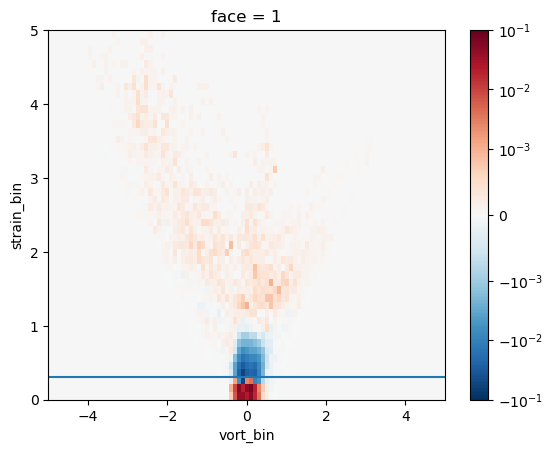

In [21]:
(h_DivPdf-h_DivPdf_pert).plot(x='vort_bin', vmax=0.1, norm=mpl.colors.SymLogNorm(1e-3))
plt.axhline(0.3)